# **CMSC 320 Final Project** 
## **Final Due Date: *Dec 09, 2025 @ 11:59 PM***
## **Group Members: Ricardo Vasquez, Justin Glazer, Jonathan Teagan, Colin Pollard**

## Checkpoint #2



**List of Imports**

In [16]:
import pandas as pd
from datetime import datetime
import string
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import sys
import numpy as np

## Data Preprocessing

**Observations on the Titanic Dataset**

In [17]:
titanic_df = pd.read_csv("Titanic-Dataset.csv")
rows_num, cols_num = titanic_df.shape
cols = titanic_df.columns.to_list()
col_types = titanic_df.dtypes.to_list()
info = titanic_df.count()
display(titanic_df.head(n=10), f"Rows: {rows_num}, Cols: {cols_num}", f"Column Names: {cols}", f"Column Types: {col_types}", info)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


'Rows: 891, Cols: 12'

"Column Names: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']"

"Column Types: [dtype('int64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('O'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('O'), dtype('float64'), dtype('O'), dtype('O')]"

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [18]:
unique_id = titanic_df['PassengerId'].is_unique
tot_unique_id = titanic_df['PassengerId'].nunique()
print("PassengerId's Unique:", unique_id, ", Total Unique:",tot_unique_id, "out of", len(titanic_df))

null_count = titanic_df.isnull().sum()
duplicates = titanic_df.duplicated().sum()
print("Null counts by category:")
print(null_count)
print("Duplicated:", duplicates)


string_cols = titanic_df.select_dtypes(include=['object']).columns
for col in string_cols:
    whitespace_count = titanic_df[col].str.strip().ne(titanic_df[col]).sum()
    if whitespace_count > 0:
        print(col, ":",whitespace_count, "entries with leading/trailing whitespace")



PassengerId's Unique: True , Total Unique: 891 out of 891
Null counts by category:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Duplicated: 0
Name : 2 entries with leading/trailing whitespace
Cabin : 687 entries with leading/trailing whitespace
Embarked : 2 entries with leading/trailing whitespace


In [19]:
# ============================================================
# 1. Extract Titles from Names
# ============================================================
conditions = [
    titanic_df['Name'].str.contains('Mr.'),
    titanic_df['Name'].str.contains('Miss.'),
    titanic_df['Name'].str.contains('Master.'),
    ~(titanic_df['Name'].str.contains('Mr.|Miss.|Master.'))
]
values = ['Mr_and_Mrs', 'Miss', 'Master', 'Other']
titanic_df['Title'] = np.select(conditions, values, default='Other')

# ============================================================
# 2. Impute Missing Age by Title Mean
# ============================================================
titanic_df['Age'] = (
    titanic_df['Age']
    .fillna(titanic_df.groupby('Title')['Age'].transform('mean'))
    .astype('int64')
)

# ============================================================
# 3. Combine SibSp + Parch → FamilySize
# ============================================================
if 'SibSp' in titanic_df.columns and 'Parch' in titanic_df.columns:
    titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch']
    titanic_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# ============================================================
# 4. Fill Missing Fare Using Median within Passenger Class
# ============================================================
if titanic_df['Fare'].isnull().sum() > 0:
    for pclass in titanic_df.loc[titanic_df['Fare'].isnull(), 'Pclass'].unique():
        median_fare = titanic_df.loc[titanic_df['Pclass'] == pclass, 'Fare'].median()
        titanic_df.loc[
            (titanic_df['Fare'].isnull()) & (titanic_df['Pclass'] == pclass),
            'Fare'
        ] = median_fare

# ============================================================
# 5. Family Survival Features (Dennis Bakhuis approach)
# ============================================================
def other_family_members_survived(dataset, label='family_survival'):
    """
    Checks whether other family members within the same surname or ticket survived.
    Returns a fractional indicator:
      - 1.0 if at least one other family member survived
      - 0.0 if no other family members survived
      - 0.5 if unknown (no family or missing data)
    """
    ds = dataset.copy()
    if len(ds) == 1:
        ds[label] = 0.5
        return ds

    result = []
    for idx, row in ds.iterrows():
        survived_fraction = ds.drop(idx)['Survived'].mean()
        if np.isnan(survived_fraction):
            result.append(0.5)
        elif survived_fraction == 0:
            result.append(0.0)
        else:
            result.append(1.0)
    ds[label] = result
    return ds

# Extract surname
titanic_df['surname'] = titanic_df['Name'].apply(lambda x: x.split(",")[0])

# Apply surname + fare family grouping
titanic_df = (
    titanic_df.groupby(['surname', 'Fare'])
    .apply(other_family_members_survived)
    .reset_index(drop=True)
)

# Apply ticket-based grouping as a secondary family identifier
titanic_df = (
    titanic_df.groupby(['Ticket'])
    .apply(lambda x: other_family_members_survived(x, label='family_survival_ticket'))
    .reset_index(drop=True)
)

# Replace unknowns (0.5) in surname-based feature with ticket-based info
mask = titanic_df['family_survival'] == 0.5
titanic_df.loc[mask, 'family_survival'] = titanic_df.loc[mask, 'family_survival_ticket']
# ============================================================
# 6. Drop Unneeded Columns
# ============================================================
cols_to_drop = ['Ticket', 'Cabin', 'PassengerId', 'family_survival_ticket']
titanic_df.drop(columns=[c for c in cols_to_drop if c in titanic_df.columns], inplace=True)

# ============================================================
# 7. Final Sanity Check
# ============================================================
print("✅ Preprocessing complete.")
print("Shape:", titanic_df.shape)
print("Missing values per column:\n", titanic_df.isnull().sum())
print("\nPreview:")
print(titanic_df.head())

/tmp/ipykernel_2924/369798375.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(other_family_members_survived)


✅ Preprocessing complete.
Shape: (891, 11)
Missing values per column:
 Survived           0
Pclass             0
Name               0
Sex                0
Age                0
Fare               0
Embarked           2
Title              0
FamilySize         0
surname            0
family_survival    0
dtype: int64

Preview:
   Survived  Pclass                                               Name  \
0         1       1                               Cherry, Miss. Gladys   
1         1       1                              Maioni, Miss. Roberta   
2         1       1  Rothes, the Countess. of (Lucy Noel Martha Dye...   
3         0       1                                  Taussig, Mr. Emil   
4         1       1             Taussig, Mrs. Emil (Tillie Mandelbaum)   

      Sex  Age   Fare Embarked       Title  FamilySize  surname  \
0  female   30  86.50        S        Miss           0   Cherry   
1  female   16  86.50        S        Miss           0   Maioni   
2  female   33  86.50        

/tmp/ipykernel_2924/369798375.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: other_family_members_survived(x, label='family_survival_ticket'))


The intresting part about cleaning the data set is that because of our practical knowledge we are able to construct further pieces of information about families or titles, and we can use that information to clean better such as filling in ages by titles, while some values were missing such as the many cabins we had to drop, this should not be a big issue as while location data could be valuable in determing links between survival and cabin, and the direct link between cabin and class, the link between class and survival is not only historically shown but is apparent with even a cursory viewing of the dataset.

## Conclusion 1

Is Sex correlated with Survival?

HO: The sex of the passanger does not affect if they survived.

HA: The sex of the passanger does affect if they survived.

$\alpha = 0.05$.

Survived,0,1
Sex,,
female,81,233
male,468,109


P-Value: 1.1973570627755645e-58


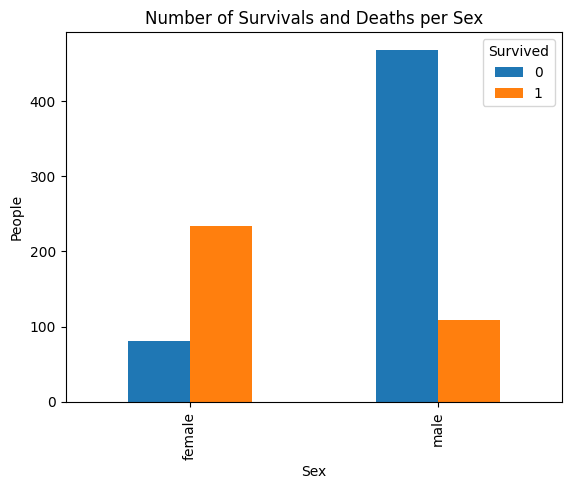

In [20]:
table = pd.crosstab(titanic_df['Sex'], titanic_df['Survived'])
display(table)
_, p_val, _, _ = chi2_contingency(table)
print(f"P-Value: {p_val}")
table.plot(kind="bar")
plt.xlabel("Sex")
plt.ylabel("People")
plt.title("Number of Survivals and Deaths per Sex")
plt.show()

With a P-Value of 1.1973570627755645e-58, this is clearly much less than the significance of 0.05. Thus, we reject the null hypothesis and find that there is a statistically significant correlation between sex and survival. This is further shown by the graph above which demonstrates women survived at a much higher rate than men. One cause of this could be the rule of "Women and Children First," leading to many men being unable to make it on a lifeboat.

## Conclusion 2

Is Age correlated with survival in Men?

HO: The age of the male passenger does not affect if they survived.

HA: The age of the male passenger does affect if they survived.

$\alpha = 0.05$.

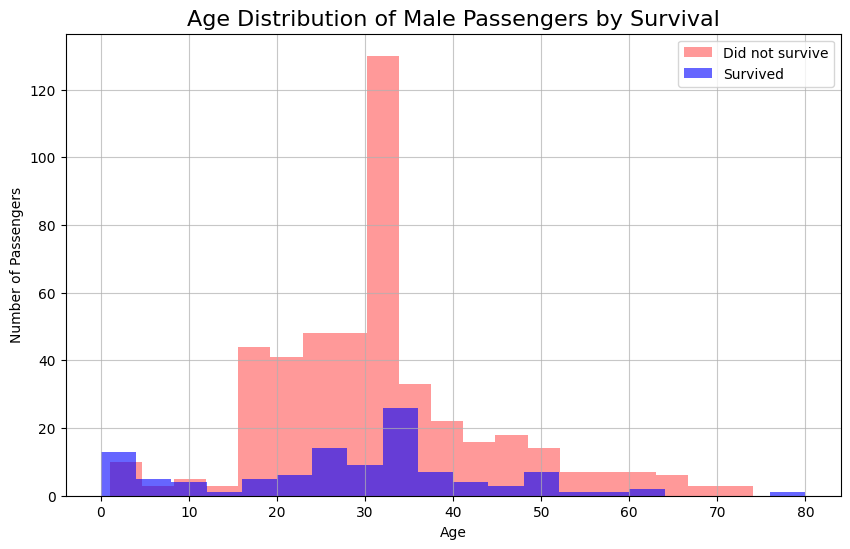

Average Age of Survivors: 27.5505 Average Std Dev of Survivors: 15.7507
Average Age of Non-Survivors: 31.8162 Average Std Dev of Non-Survivors: 12.4739
P-value: 0.0092


In [21]:
men = titanic_df[titanic_df['Sex'] == 'male']
men = men.dropna(subset=['Age'])

survivors = men[men["Survived"] == 1]["Age"]
nonsurvivors = men[men["Survived"] == 0]["Age"]
_, p_val = ttest_ind(survivors, nonsurvivors, equal_var=False)
plt.figure(figsize=(10,6))
plt.hist(nonsurvivors, bins=20, alpha=0.4, color="red", label="Did not survive")
plt.hist(survivors, bins=20, alpha=0.6, color="blue", label="Survived")
plt.title("Age Distribution of Male Passengers by Survival", fontsize=16)
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

print("Average Age of Survivors:", round(survivors.mean(), 4), "Average Std Dev of Survivors:", round(survivors.std(), 4))
print("Average Age of Non-Survivors:", round(nonsurvivors.mean(), 4), "Average Std Dev of Non-Survivors:", round(nonsurvivors.std(), 4))
print(f"P-value: {p_val:.4f}")

## Conclusion 3

Is the Passengers' ticket classes correlated with their survival?

HO: Ticket class has no effect on the survival of the passengers.

HA: Ticket class has an effect on the survival of the passengers.

Alpha = 0.05



Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


Chi-square test p-value: 4.549251711298793e-23


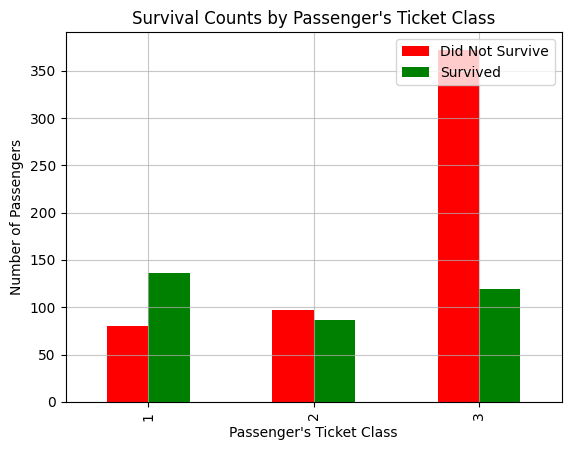

Survival Rates by Class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


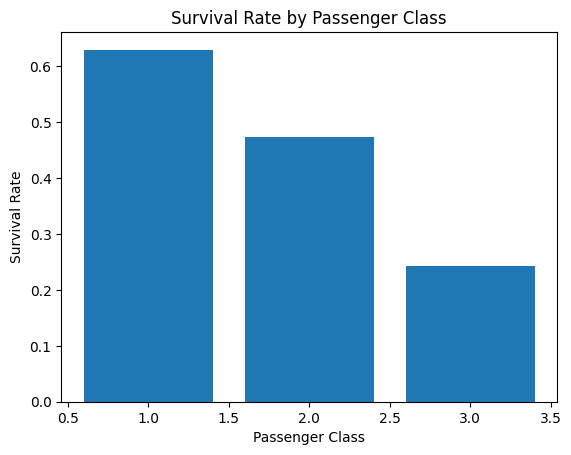

In [22]:
class_table = pd.crosstab(titanic_df['Pclass'], titanic_df['Survived'])
display(class_table)
_, p_val, _, _ = chi2_contingency(class_table)
print(f"Chi-square test p-value: {p_val}")

class_table.plot(kind="bar", stacked=False, color=["red", "green"])
plt.title("Survival Counts by Passenger's Ticket Class")
plt.xlabel("Passenger's Ticket Class")
plt.ylabel("Number of Passengers")
plt.legend(["Did Not Survive", "Survived"], loc="upper right")
plt.grid(alpha=0.7)
plt.show()

survival_rate_by_class = titanic_df.groupby("Pclass")["Survived"].mean()
print("Survival Rates by Class:")
print(survival_rate_by_class)

plt.bar(survival_rate_by_class.index, survival_rate_by_class.values)
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()


As seen above, I executed a chi-square test to determine if there is a correlation between a passenger ticket class and passenger survival. The test yielded a p-value of 4.5493e-23, which is extremely small and far below the alpha value of 0.05. Thus passenger class and passenger survival are correlated.

The bar chart I created shows that first-class passengers had by far the highests rate of survival, and third-class passengers had by far the lowest rate of survival. This is likely due to both: the differing cabin locations of different ticket classes; and the differing levels of evacuation priority that comes with higher-class tickets.